In [1]:
from sage.matrix.berlekamp_massey import berlekamp_massey
from sage.matrix.special import *
import random
def rand_list(n, card):
    return [random.randint(0, card) for _ in range(n)]

In [2]:
ref = ['Random Diagonal', 'Identity', 'Toeplitz', 'Jordan', 'Sparse', 'Companion']
def mat_gen(q, n):
    D = diagonal_matrix(GF(q), rand_list(n, q))
    I = identity_matrix(GF(q), n)
    T = toeplitz(rand_list(n, q), rand_list(n - 1, q), GF(q))
    J = jordan_block(random.randint(2, q), n)
    S = random_matrix(GF(q), n, n, sparse=True, density=0.1)
    R.<x> = PolynomialRing(GF(q))
    coeffs = [GF(q).random_element() for _ in range(n)]
    poly = x^n + sum([coeffs[i] * x^i for i in range(n)])
    C = companion_matrix(poly)
    return [D, I, T, J, S, C]

In [3]:
def krylov(u, v, A, m, start = 0):
    return [u*(A^i*v) for i in range(start, m)]

def random_vector(n, f):
    return vector(f, [f.random_element() for _ in range(n)])

In [4]:
# def early_BM(q, sequence, n, c=3):
#     ω = c*log(n, q) + 1
#     f = GF(q)
#     R = PolynomialRing(f, "x")
#     sequence = [f(s) for s in sequence]
#     C = [f(1)]
#     B = [f(1)]
#     L = 0
#     m = 1
#     streak = 1
#     b = f(1)
#     stop = 0
#     for k in range(len(sequence)):
#         d = sequence[k] + sum(C[i] * sequence[k - i] for i in range(1, L + 1))
#         if d == 0:
#             m += 1
#             streak += 1
#             if streak >= ω:
#                 stop = k
#                 break
#         elif 2 * L <= k:
#             T = C[:]
#             C += [f(0)] * (m + len(B) - len(C))
#             for i in range(len(B)):
#                 C[i + m] -= d / b * B[i]
#             L = k + 1 - L
#             B = T
#             b = d
#             m = 1
#             streak = 1
#         else:
#             C += [f(0)] * (m + len(B) - len(C))
#             for i in range(len(B)):
#                 C[i + m] -= d / b * B[i]
#             m += 1
#             streak = 1
#     else: 
#         stop = 2*n
#     # result processing before return
#     C = C[::-1]
#     while len(C) > 1 and C[0] == 0:
#         C = C[1:]
#     return R(C), stop

In [5]:
import matplotlib.pyplot as plt

def plot_success(success_map, x_list, x_lab='x'):
    min_success = 1
    plt.figure(figsize=(10, 6))
    
    for mat_type, success_list in success_map.items():
        min_success = min(min_success, min(success_list))
        plt.plot(x_list, success_list,'--', label=mat_type)
    
    plt.title('Success Probability by Matrix Type', fontsize=14)
    plt.xlabel(x_lab)
    plt.ylabel('Prob.')
    plt.ylim(-0.1, 1.1)
    plt.legend(title='Matrix Type')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f'Min success rate: {float(min_success):.3f}')


def plot_stops(stops_map, x_list, comp_list, x_lab='x', y_lim=None):
    plt.figure(figsize=(10, 6))

    for mat_type, stops_list in stops_map.items():
        plt.plot(x_list, stops_list, label=f'{mat_type} - Early term')

    # Plot comparison line once
    plt.plot(x_list, comp_list, '--', label='Standard term. at iter. 2n')

    plt.title('Avg. Stop by Matrix Type', fontsize=14)
    plt.xlabel(x_lab)
    plt.ylabel('k')
    if y_lim:
        plt.ylim(y_lim)
    plt.legend(title='Legend')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
def varyingN(q = 5, n_lim = 51, trials = 100):
    n_list = [i for i in range(1, n_lim)]
    f = GF(q)
    avg_stops = {}
    success_rates = {}
    for n in n_list:
        print(n)
        matlist = mat_gen(q, n)
        for i in range(6):
            sum_stop = 0
            failed = 0
            A = matlist[i]
            minpoly = A.minpoly()
            mat_type = ref[i]
            for _ in range(trials):
                u = random_vector(n, f)
                v = random_vector(n, f)
                k = krylov(u, v, A, 2*n)
                # b_temp, stop = early_BM(q, k, n)
                # sum_stop += stop
                b = berlekamp_massey(k)
                if b!=minpoly:
                    failed += 1
            success_rates.setdefault(mat_type, []).append(1 - failed / trials)
            avg_stops.setdefault(mat_type, []).append(sum_stop / trials)
    plot_success(success_rates, n_list, x_lab = 'n')
    # comp_list = [2*i for i in n_list]
    # plot_stops(avg_stops, n_list, comp_list, x_lab = 'n')
    return success_rates

In [7]:
def varyingQ(n = 40, q_lim = 100, trials = 100):
    q_list = prime_range(0, q_lim)
    avg_stops = {}
    success_rates = {}
    for q in q_list:
        print(q)
        f = GF(q)
        matlist = mat_gen(q, n)
        for i in range(6):
            sum_stop = 0
            failed = 0
            A = matlist[i]
            minpoly = A.minpoly()
            mat_type = ref[i]
            for _ in range(trials):
                u = random_vector(n, f)
                v = random_vector(n, f)
                k = krylov(u, v, A, 2*n)
                # b_temp, stop = early_BM(q, k, n)
                # sum_stop += stop
                b = berlekamp_massey(k)
                if b!=minpoly:
                    failed += 1
            success_rates.setdefault(mat_type, []).append(float(1 - failed / trials))
            avg_stops.setdefault(mat_type, []).append(float(sum_stop / trials))
    plot_success(success_rates, q_list, x_lab = 'q')
    return success_rates
    # comp_list = [2*n]*len(q_list)
    # plot_stops(avg_stops, q_list, comp_list, x_lab = 'q', y_lim = (0, 2*n + 1))
    # return avg_stops, success_rates

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


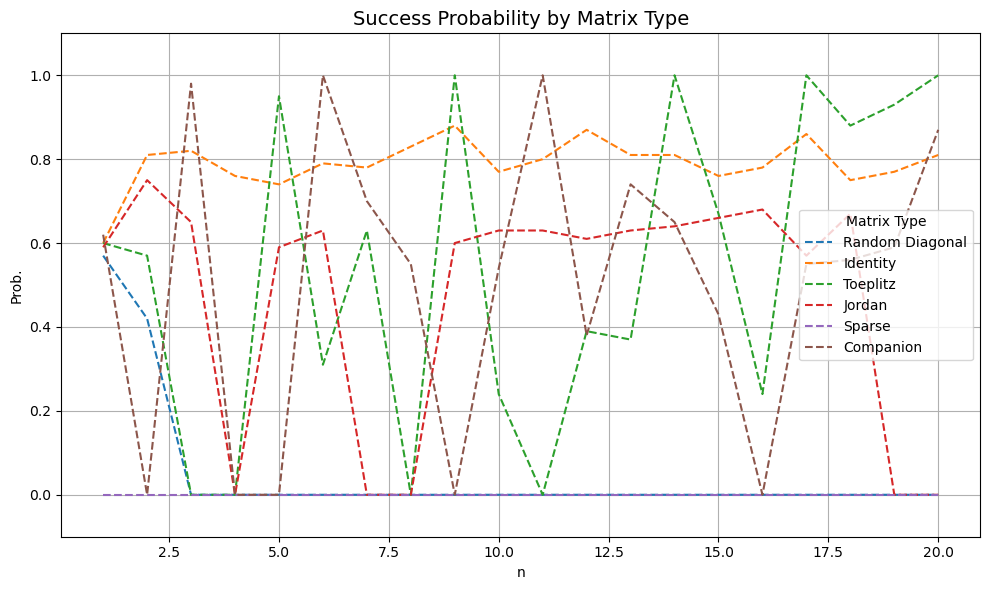

Min success rate: 0.000


In [8]:
vN = varyingN(n_lim = 21, trials=100)

2
3
5
7
11
13
17
19
23
29
31
37
41
43
47


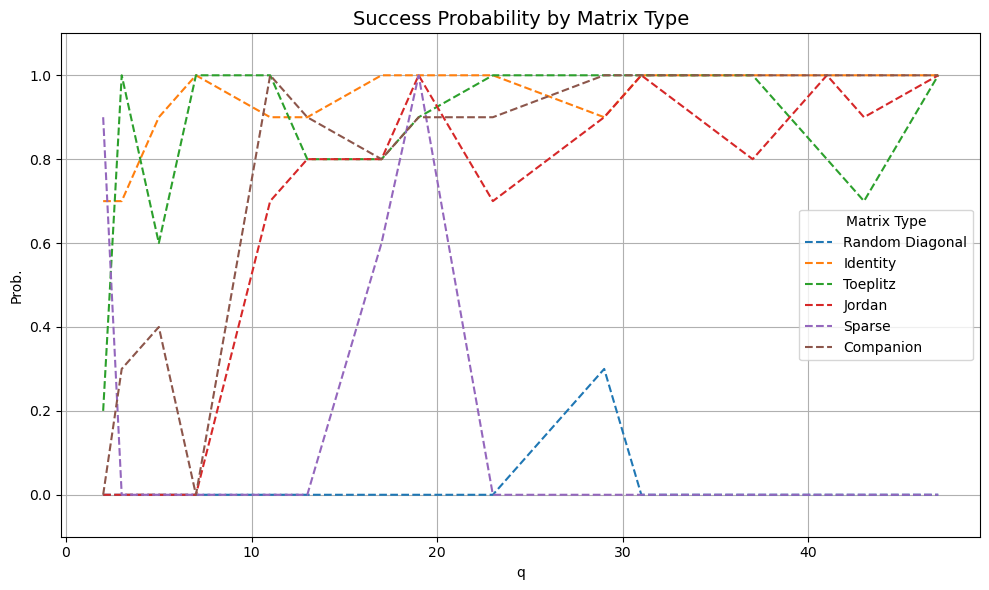

Min success rate: 0.000


In [9]:
vQ = varyingQ(q_lim=50, trials=10)

In [10]:
# check jordan's success rate
# varying jordan block size & diagonals
# wiedemann's min poly success with same test cases